# MyNextMovie - Movie Recommendation System

## Overview
This notebook implements a comprehensive movie recommendation system for MyNextMovie startup using three different approaches:
1. **Popularity-Based Recommender**: Recommends popular movies within a specific genre
2. **Content-Based Recommender**: Recommends movies based on genre similarity
3. **Collaborative Filtering Recommender**: Recommends movies based on similar users' preferences

## Dataset
- **Movies Dataset**: 10,329 movies with movieId, title, and genres
- **Ratings Dataset**: 105,339 ratings from 668 users
- **Rating Scale**: 0.5 to 5.0 with average rating of 3.5

## 1. Import Libraries and Load Dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jaccard
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load datasets
movies_df = pd.read_csv('../data/raw/movies.csv')
ratings_df = pd.read_csv('../data/raw/ratings.csv')

print("Dataset loaded successfully!")
print(f"Movies dataset shape: {movies_df.shape}")
print(f"Ratings dataset shape: {ratings_df.shape}")

Dataset loaded successfully!
Movies dataset shape: (10329, 3)
Ratings dataset shape: (105339, 4)


In [3]:
# Initial data inspection
print("=== MOVIES DATASET ===")
print(movies_df.head())
print("\nMovies Dataset Info:")
print(movies_df.info())
print("\nMovies Dataset Description:")
print(movies_df.describe())

print("\n=== RATINGS DATASET ===")
print(ratings_df.head())
print("\nRatings Dataset Info:")
print(ratings_df.info())
print("\nRatings Dataset Description:")
print(ratings_df.describe())

=== MOVIES DATASET ===
   movieId                               title                                       genres
0        1                    Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2                      Jumanji (1995)                   Adventure|Children|Fantasy
2        3             Grumpier Old Men (1995)                               Comedy|Romance
3        4            Waiting to Exhale (1995)                         Comedy|Drama|Romance
4        5  Father of the Bride Part II (1995)                                       Comedy

Movies Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB
None

Movies Dataset Description:
             movieId
cou

## 2. Exploratory Data Analysis

In [4]:
# Basic statistics
print("=== BASIC STATISTICS ===")
print(f"Total number of movies: {movies_df['movieId'].nunique()}")
print(f"Total number of users: {ratings_df['userId'].nunique()}")
print(f"Total number of ratings: {len(ratings_df)}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")
print(f"Minimum rating: {ratings_df['rating'].min()}")
print(f"Maximum rating: {ratings_df['rating'].max()}")
print(f"Rating sparsity: {(len(ratings_df) / (movies_df['movieId'].nunique() * ratings_df['userId'].nunique())) * 100:.2f}%")

=== BASIC STATISTICS ===
Total number of movies: 10329
Total number of users: 668
Total number of ratings: 105339
Average rating: 3.52
Minimum rating: 0.5
Maximum rating: 5.0
Rating sparsity: 1.53%


In [5]:
# Check for missing values
print("=== MISSING VALUES ===")
print("Movies dataset missing values:")
print(movies_df.isnull().sum())
print("\nRatings dataset missing values:")
print(ratings_df.isnull().sum())

=== MISSING VALUES ===
Movies dataset missing values:
movieId    0
title      0
genres     0
dtype: int64

Ratings dataset missing values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


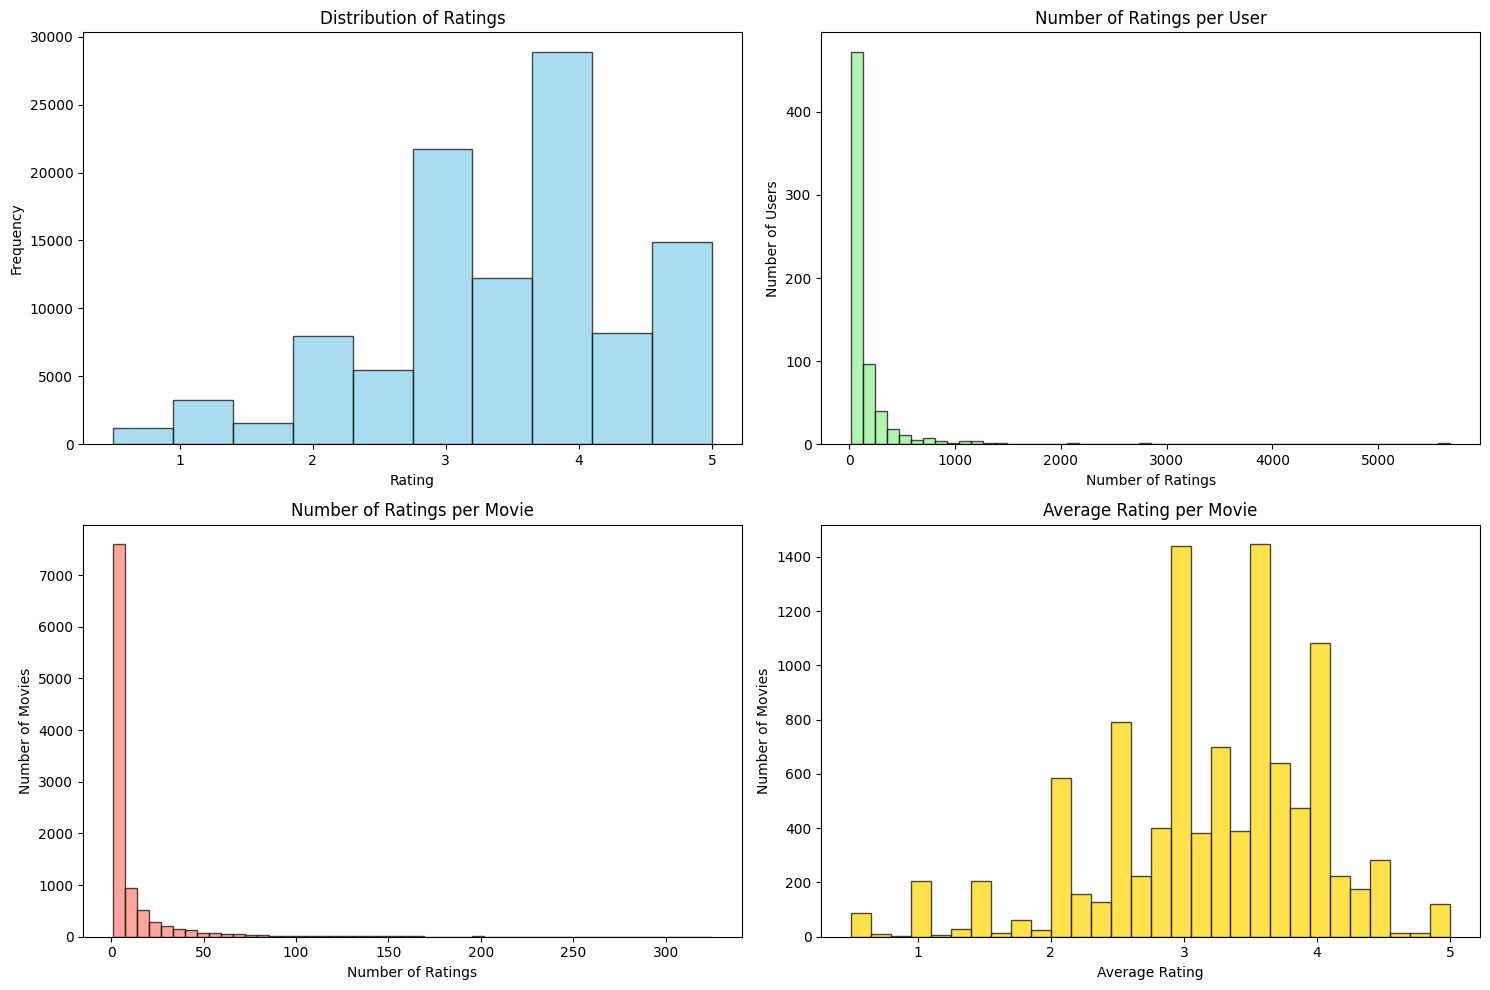

Most active user rated 5678 movies
Most rated movie has 325 ratings
Average number of ratings per user: 157.69
Average number of ratings per movie: 10.20


In [6]:
# Rating distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating distribution
axes[0, 0].hist(ratings_df['rating'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Ratings')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')

# Number of ratings per user
user_rating_counts = ratings_df['userId'].value_counts()
axes[0, 1].hist(user_rating_counts, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Number of Ratings per User')
axes[0, 1].set_xlabel('Number of Ratings')
axes[0, 1].set_ylabel('Number of Users')

# Number of ratings per movie
movie_rating_counts = ratings_df['movieId'].value_counts()
axes[1, 0].hist(movie_rating_counts, bins=50, alpha=0.7, color='salmon', edgecolor='black')
axes[1, 0].set_title('Number of Ratings per Movie')
axes[1, 0].set_xlabel('Number of Ratings')
axes[1, 0].set_ylabel('Number of Movies')

# Average rating per movie
movie_avg_ratings = ratings_df.groupby('movieId')['rating'].mean()
axes[1, 1].hist(movie_avg_ratings, bins=30, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('Average Rating per Movie')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Number of Movies')

plt.tight_layout()
plt.show()

print(f"Most active user rated {user_rating_counts.max()} movies")
print(f"Most rated movie has {movie_rating_counts.max()} ratings")
print(f"Average number of ratings per user: {user_rating_counts.mean():.2f}")
print(f"Average number of ratings per movie: {movie_rating_counts.mean():.2f}")

In [8]:
# Genre analysis
print("=== GENRE ANALYSIS ===")

# Split genres and create a list of all genres
all_genres = []
for genres_str in movies_df['genres'].dropna():
    genres = genres_str.split('|')
    all_genres.extend(genres)

# Count genre frequency
genre_counts = pd.Series(all_genres).value_counts()
print(f"Total unique genres: {len(genre_counts)}")
print("\nTop 10 most common genres:")
print(genre_counts.head(10))



=== GENRE ANALYSIS ===
Total unique genres: 20

Top 10 most common genres:
Drama        5220
Comedy       3515
Thriller     2187
Romance      1788
Action       1737
Crime        1440
Adventure    1164
Horror       1001
Sci-Fi        860
Mystery       675
Name: count, dtype: int64


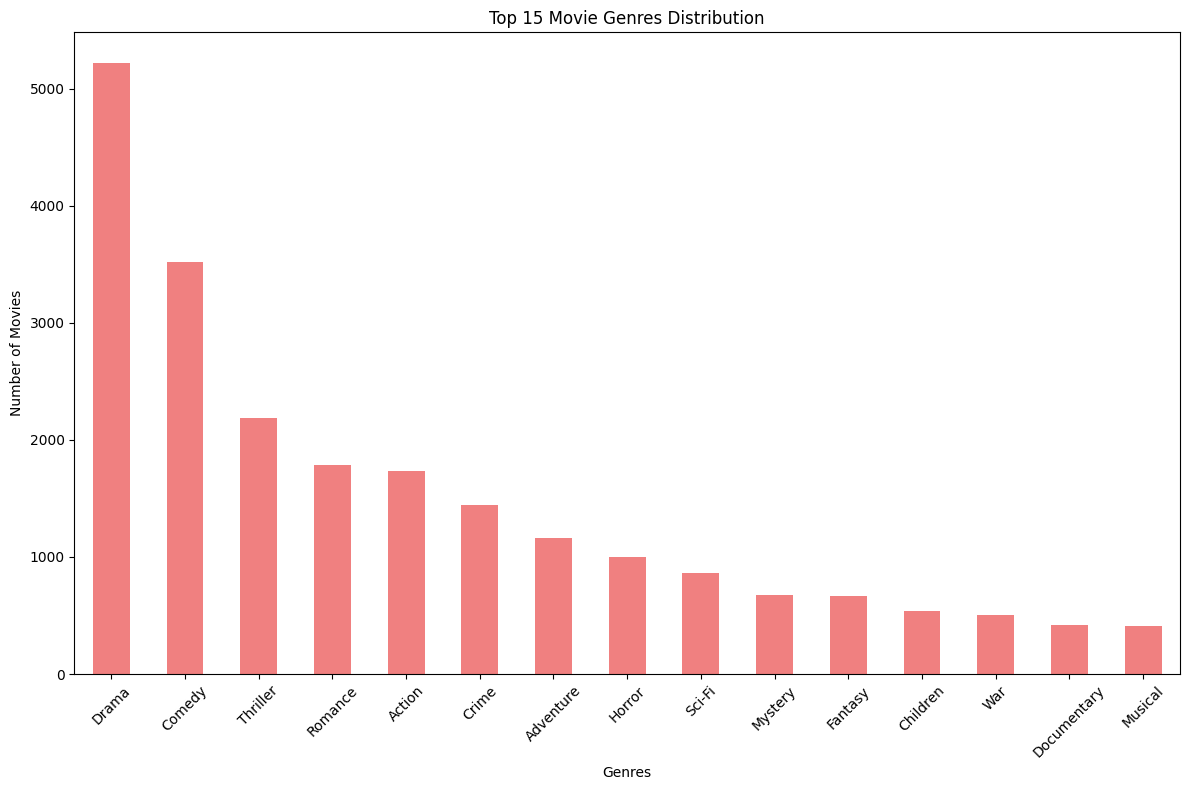

In [9]:
# Plot genre distribution
plt.figure(figsize=(12, 8))
genre_counts.head(15).plot(kind='bar', color='lightcoral')
plt.title('Top 15 Movie Genres Distribution')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Genre-level statistics
def get_genre_stats():
    """Calculate average rating and total movies for each genre"""
    genre_stats = {}
    
    for genre in genre_counts.index:
        # Find movies with this genre
        genre_movies = movies_df[movies_df['genres'].str.contains(genre, na=False)]
        
        # Get ratings for these movies
        genre_ratings = ratings_df[ratings_df['movieId'].isin(genre_movies['movieId'])]
        
        if len(genre_ratings) > 0:
            avg_rating = genre_ratings['rating'].mean()
            total_movies = len(genre_movies)
            total_ratings = len(genre_ratings)
            
            genre_stats[genre] = {
                'avg_rating': avg_rating,
                'total_movies': total_movies,
                'total_ratings': total_ratings
            }
    
    return pd.DataFrame(genre_stats).T

genre_stats_df = get_genre_stats()
genre_stats_df = genre_stats_df.sort_values('avg_rating', ascending=False)

print("Genre-level Statistics (Top 10 by Average Rating):")
print(genre_stats_df.head(10).round(2))



Genre-level Statistics (Top 10 by Average Rating):
             avg_rating  total_movies  total_ratings
Film-Noir          3.91         195.0         1210.0
War                3.78         503.0         5828.0
Mystery            3.65         675.0         8320.0
Drama              3.65        5220.0        46960.0
Documentary        3.64         415.0         1206.0
Crime              3.64        1440.0        18291.0
IMAX               3.64         152.0         3032.0
Animation          3.64         401.0         5966.0
Musical            3.57         409.0         4287.0
Western            3.57         235.0         2314.0


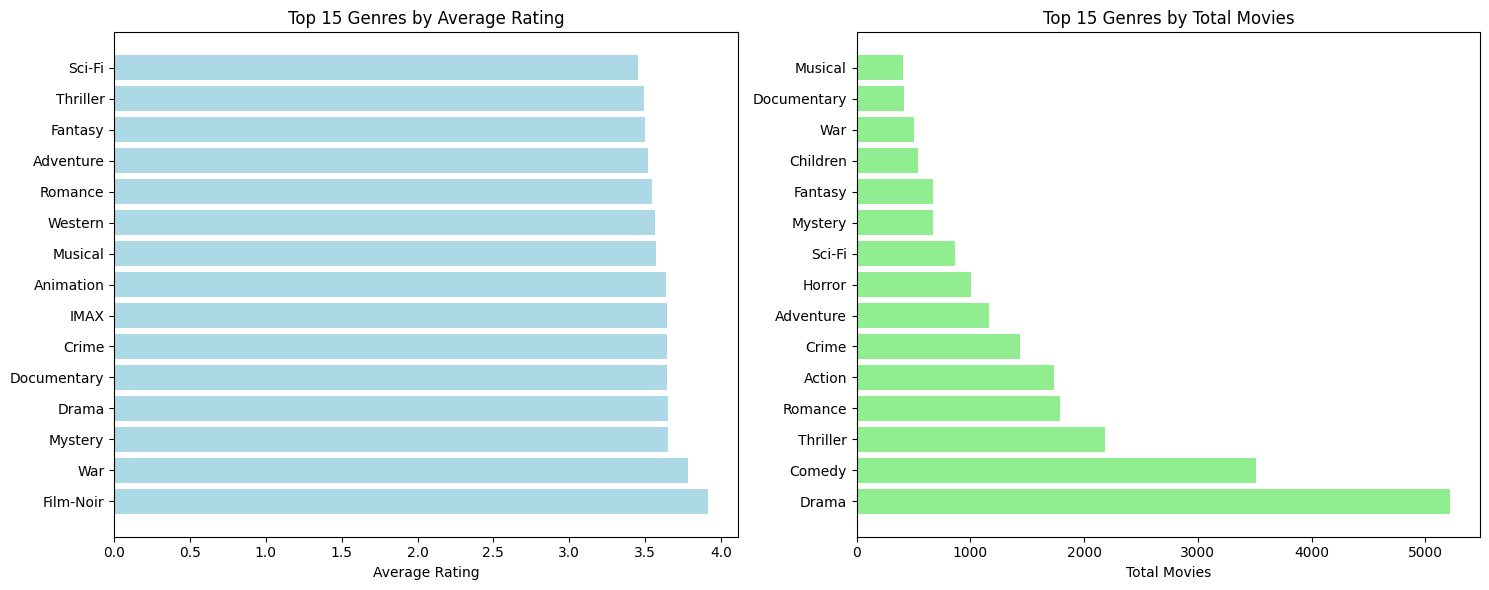

In [11]:
# Visualize genre statistics
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Average rating by genre (top 15)
top_genres = genre_stats_df.head(15)
axes[0].barh(range(len(top_genres)), top_genres['avg_rating'], color='lightblue')
axes[0].set_yticks(range(len(top_genres)))
axes[0].set_yticklabels(top_genres.index)
axes[0].set_xlabel('Average Rating')
axes[0].set_title('Top 15 Genres by Average Rating')

# Total movies by genre (top 15)
top_movie_genres = genre_stats_df.sort_values('total_movies', ascending=False).head(15)
axes[1].barh(range(len(top_movie_genres)), top_movie_genres['total_movies'], color='lightgreen')
axes[1].set_yticks(range(len(top_movie_genres)))
axes[1].set_yticklabels(top_movie_genres.index)
axes[1].set_xlabel('Total Movies')
axes[1].set_title('Top 15 Genres by Total Movies')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing and Feature Engineering

In [ ]:
# Create genre-expanded dataframe for content-based filtering
def expand_genres(df):
    """Expand the genres column into separate binary columns for each genre"""
    # Get all unique genres
    all_genres_set = set()
    for genres_str in df['genres'].dropna():
        genres = genres_str.split('|')
        all_genres_set.update(genres)
    
    # Create binary columns for each genre
    df_expanded = df.copy()
    for genre in all_genres_set:
        df_expanded[f'genre_{genre}'] = df_expanded['genres'].str.contains(genre, na=False).astype(int)
    
    return df_expanded, list(all_genres_set)

movies_expanded, unique_genres = expand_genres(movies_df)
print(f"Created {len(unique_genres)} genre columns")
print(f"Expanded movies dataframe shape: {movies_expanded.shape}")
print(f"Unique genres: {unique_genres[:5]}...")  # Show first 5 genres

Created 20 genre columns
Expanded movies dataframe shape: (10329, 23)
Unique genres: ['Adventure', 'Horror', 'Mystery', 'Children', 'Documentary']...


In [14]:
# Create user-movie rating matrix for collaborative filtering
user_movie_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating')
print(f"User-movie matrix shape: {user_movie_matrix.shape}")
print(f"Matrix sparsity: {(user_movie_matrix.isnull().sum().sum() / (user_movie_matrix.shape[0] * user_movie_matrix.shape[1])) * 100:.2f}%")



User-movie matrix shape: (668, 10325)
Matrix sparsity: 98.47%


In [15]:
# Fill NaN values with 0 for collaborative filtering
user_movie_matrix_filled = user_movie_matrix.fillna(0)
print("User-movie matrix created and filled with zeros for missing values")

User-movie matrix created and filled with zeros for missing values


In [18]:
# Create movie statistics for popularity-based filtering
movie_stats = ratings_df.groupby('movieId').agg({
    'rating': ['mean', 'count', 'std']
}).round(2)

# Flatten column names
movie_stats.columns = ['avg_rating', 'num_ratings', 'rating_std']
movie_stats = movie_stats.reset_index()

# Merge with movies dataframe
movies_with_stats = movies_df.merge(movie_stats, on='movieId', how='left')
movies_with_stats = movies_with_stats.fillna(0)

print("Movie statistics calculated and merged:")
print("-------------------------------\n")
print(movies_with_stats.head())
print("\n-------------------------------")
print(f"Movies with statistics shape: {movies_with_stats.shape}")

Movie statistics calculated and merged:
-------------------------------

   movieId                               title                                       genres  avg_rating  num_ratings  rating_std
0        1                    Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy        3.91        232.0        0.83
1        2                      Jumanji (1995)                   Adventure|Children|Fantasy        3.35         92.0        0.78
2        3             Grumpier Old Men (1995)                               Comedy|Romance        3.19         58.0        0.91
3        4            Waiting to Exhale (1995)                         Comedy|Drama|Romance        2.82         11.0        0.96
4        5  Father of the Bride Part II (1995)                                       Comedy        3.25         62.0        0.85

-------------------------------
Movies with statistics shape: (10329, 6)


## 4. Popularity-Based Recommendation System

This system recommends the most popular movies within a specific genre based on:
- Average rating
- Minimum number of reviews threshold
- Genre filtering

In [19]:
def popularity_based_recommender(genre, min_reviews_threshold, num_recommendations):
    """
    Recommend top N popular movies within a specific genre
    
    Parameters:
    genre (str): Genre to filter movies
    min_reviews_threshold (int): Minimum number of reviews required
    num_recommendations (int): Number of recommendations to return
    
    Returns:
    DataFrame: Top N movies with S.No., Movie Title, Average Rating, and Num Reviews
    """
    
    # Filter movies by genre
    genre_movies = movies_with_stats[movies_with_stats['genres'].str.contains(genre, case=False, na=False)]
    
    # Filter by minimum reviews threshold
    popular_movies = genre_movies[genre_movies['num_ratings'] >= min_reviews_threshold]
    
    if len(popular_movies) == 0:
        return pd.DataFrame(columns=['S.No.', 'Movie Title', 'Average Movie Rating', 'Num Reviews'])
    
    # Sort by average rating (descending) and then by number of ratings (descending)
    popular_movies = popular_movies.sort_values(['avg_rating', 'num_ratings'], ascending=[False, False])
    
    # Select top N recommendations
    top_movies = popular_movies.head(num_recommendations)
    
    # Create result dataframe
    result = pd.DataFrame({
        'S.No.': range(1, len(top_movies) + 1),
        'Movie Title': top_movies['title'].values,
        'Average Movie Rating': top_movies['avg_rating'].values,
        'Num Reviews': top_movies['num_ratings'].astype(int).values
    })
    
    return result



In [22]:
# Test the popularity-based recommender
print("=== POPULARITY-BASED RECOMMENDER TEST ===")
print("\nExample 1: Genre=Comedy, Min Reviews=100, Recommendations=5")
comedy_recommendations = popularity_based_recommender('Comedy', 100, 5)
comedy_recommendations



=== POPULARITY-BASED RECOMMENDER TEST ===

Example 1: Genre=Comedy, Min Reviews=100, Recommendations=5


,S.No.,Movie Title,Average Movie Rating,Num Reviews
0,1,Monty Python and the Holy Grail (1975),4.30,154
1,2,Fargo (1996),4.27,201
2,3,Pulp Fiction (1994),4.16,325
3,4,"Princess Bride, The (1987)",4.16,171
4,5,Forrest Gump (1994),4.14,311


In [24]:
print("\nExample 2: Genre=Action, Min Reviews=50, Recommendations=5")
action_recommendations = popularity_based_recommender('Action', 50, 5)
action_recommendations




Example 2: Genre=Action, Min Reviews=50, Recommendations=5


,S.No.,Movie Title,Average Movie Rating,Num Reviews
0,1,Princess Mononoke (Mononoke-hime) (1997),4.38,52
1,2,North by Northwest (1959),4.27,73
2,3,"Matrix, The (1999)",4.26,261
3,4,Star Wars: Episode V - The Empire Strikes Back...,4.23,228
4,5,Seven Samurai (Shichinin no samurai) (1954),4.22,62


In [25]:
print("\nExample 3: Genre=Drama, Min Reviews=75, Recommendations=3")
drama_recommendations = popularity_based_recommender('Drama', 75, 3)
drama_recommendations


Example 3: Genre=Drama, Min Reviews=75, Recommendations=3


,S.No.,Movie Title,Average Movie Rating,Num Reviews
0,1,"Shawshank Redemption, The (1994)",4.45,308
1,2,Citizen Kane (1941),4.40,77
2,3,"Godfather, The (1972)",4.39,210


## 5. Content-Based Recommendation System

This system recommends movies based on genre similarity using:
- Genre feature vectors
- Cosine similarity calculation
- Movie title input matching

In [26]:
def content_based_recommender(movie_title, num_recommendations):
    """
    Recommend movies similar to a given movie based on genre similarity
    
    Parameters:
    movie_title (str): Title of the input movie
    num_recommendations (int): Number of recommendations to return
    
    Returns:
    DataFrame: Top N similar movies with S.No. and Movie Titles
    """
    
    # Find the movie in the dataset (case-insensitive partial matching)
    movie_matches = movies_expanded[movies_expanded['title'].str.contains(movie_title, case=False, na=False)]
    
    if len(movie_matches) == 0:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return pd.DataFrame(columns=['S.No.', 'Movie Title'])
    
    # If multiple matches, take the first one
    input_movie = movie_matches.iloc[0]
    input_movie_id = input_movie['movieId']
    
    print(f"Found movie: {input_movie['title']}")
    print(f"Genres: {input_movie['genres']}")
    
    # Get genre features for the input movie
    genre_columns = [col for col in movies_expanded.columns if col.startswith('genre_')]
    input_features = input_movie[genre_columns].values.reshape(1, -1)
    
    # Calculate similarity with all other movies
    all_features = movies_expanded[genre_columns].values
    similarity_scores = cosine_similarity(input_features, all_features).flatten()
    
    # Create similarity dataframe
    similarity_df = pd.DataFrame({
        'movieId': movies_expanded['movieId'],
        'title': movies_expanded['title'],
        'genres': movies_expanded['genres'],
        'similarity': similarity_scores
    })
    
    # Remove the input movie itself
    similarity_df = similarity_df[similarity_df['movieId'] != input_movie_id]
    
    # Sort by similarity score (descending)
    similarity_df = similarity_df.sort_values('similarity', ascending=False)
    
    # Select top N recommendations
    top_similar = similarity_df.head(num_recommendations)
    
    # Create result dataframe
    result = pd.DataFrame({
        'S.No.': range(1, len(top_similar) + 1),
        'Movie Title': top_similar['title'].values
    })
    
    return result



In [27]:
# Test the content-based recommender
print("=== CONTENT-BASED RECOMMENDER TEST ===")
print("\nExample 1: Movie=Toy Story, Recommendations=5")
toy_story_recommendations = content_based_recommender('Toy Story', 5)
toy_story_recommendations



=== CONTENT-BASED RECOMMENDER TEST ===

Example 1: Movie=Toy Story, Recommendations=5
Found movie: Toy Story (1995)
Genres: Adventure|Animation|Children|Comedy|Fantasy


,S.No.,Movie Title
0,1,Asterix and the Vikings (Astérix et les Viking...
1,2,"Wild, The (2006)"
2,3,Shrek the Third (2007)
3,4,"Boxtrolls, The (2014)"
4,5,Antz (1998)


In [28]:
print("\nExample 2: Movie=Matrix, Recommendations=5")
matrix_recommendations = content_based_recommender('Matrix', 5)
matrix_recommendations




Example 2: Movie=Matrix, Recommendations=5
Found movie: Matrix, The (1999)
Genres: Action|Sci-Fi|Thriller


,S.No.,Movie Title
0,1,Solo (1996)
1,2,Cypher (2002)
2,3,Predator (1987)
3,4,Screamers (1995)
4,5,"Terminator, The (1984)"


In [29]:
print("\nExample 3: Movie=Forrest Gump, Recommendations=3")
forrest_recommendations = content_based_recommender('Forrest Gump', 3)
forrest_recommendations


Example 3: Movie=Forrest Gump, Recommendations=3
Found movie: Forrest Gump (1994)
Genres: Comedy|Drama|Romance|War


,S.No.,Movie Title
0,1,Train of Life (Train de vie) (1998)
1,2,I Served the King of England (Obsluhoval jsem ...
2,3,Life Is Beautiful (La Vita è bella) (1997)


## 6. Collaborative Filtering Recommendation System

This system recommends movies based on similar users' preferences using:
- User-based collaborative filtering
- Cosine similarity between users
- K similar users threshold

In [30]:
def collaborative_filtering_recommender(user_id, num_recommendations, k_similar_users=100):
    """
    Recommend movies based on K similar users for a target user
    
    Parameters:
    user_id (int): Target user ID
    num_recommendations (int): Number of recommendations to return
    k_similar_users (int): Number of similar users to consider
    
    Returns:
    DataFrame: Top N movie recommendations with S.No. and Movie Titles
    """
    
    # Check if user exists
    if user_id not in user_movie_matrix.index:
        print(f"User {user_id} not found in the dataset.")
        return pd.DataFrame(columns=['S.No.', 'Movie Title'])
    
    # Get the target user's ratings
    target_user_ratings = user_movie_matrix_filled.loc[user_id].values.reshape(1, -1)
    
    # Calculate similarity with all other users
    user_similarities = cosine_similarity(target_user_ratings, user_movie_matrix_filled.values).flatten()
    
    # Create similarity dataframe
    similarity_df = pd.DataFrame({
        'userId': user_movie_matrix_filled.index,
        'similarity': user_similarities
    })
    
    # Remove the target user and sort by similarity
    similarity_df = similarity_df[similarity_df['userId'] != user_id]
    similarity_df = similarity_df.sort_values('similarity', ascending=False)
    
    # Get top K similar users
    top_k_users = similarity_df.head(k_similar_users)['userId'].values
    
    print(f"Found {len(top_k_users)} similar users for User {user_id}")
    print(f"Top 5 similar users: {top_k_users[:5]}")
    
    # Get movies that the target user hasn't rated
    target_user_rated_movies = user_movie_matrix.loc[user_id].dropna().index
    all_movies = set(user_movie_matrix.columns)
    unrated_movies = list(all_movies - set(target_user_rated_movies))
    
    # Calculate weighted average ratings for unrated movies
    movie_scores = {}
    
    for movie_id in unrated_movies:
        # Get ratings from similar users for this movie
        similar_users_ratings = []
        similar_users_similarities = []
        
        for sim_user_id in top_k_users:
            if movie_id in user_movie_matrix.columns and sim_user_id in user_movie_matrix.index:
                rating = user_movie_matrix.loc[sim_user_id, movie_id]
                if pd.notna(rating):  # If the similar user has rated this movie
                    user_sim = similarity_df[similarity_df['userId'] == sim_user_id]['similarity'].iloc[0]
                    similar_users_ratings.append(rating)
                    similar_users_similarities.append(user_sim)
        
        # Calculate weighted average if we have ratings
        if len(similar_users_ratings) > 0:
            weighted_rating = np.average(similar_users_ratings, weights=similar_users_similarities)
            movie_scores[movie_id] = weighted_rating
    
    if len(movie_scores) == 0:
        print("No recommendations could be generated.")
        return pd.DataFrame(columns=['S.No.', 'Movie Title'])
    
    # Sort movies by predicted rating
    sorted_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Get top N recommendations
    top_movie_ids = [movie_id for movie_id, score in sorted_movies[:num_recommendations]]
    
    # Get movie titles
    recommended_movies = movies_df[movies_df['movieId'].isin(top_movie_ids)]
    
    # Preserve the order of recommendations
    recommended_movies = recommended_movies.set_index('movieId').loc[top_movie_ids].reset_index()
    
    # Create result dataframe
    result = pd.DataFrame({
        'S.No.': range(1, len(recommended_movies) + 1),
        'Movie Title': recommended_movies['title'].values
    })
    
    return result



In [31]:
# Test the collaborative filtering recommender
print("=== COLLABORATIVE FILTERING RECOMMENDER TEST ===")
print("\nExample 1: UserID=1, Recommendations=5, K=100")
user1_recommendations = collaborative_filtering_recommender(1, 5, 100)
user1_recommendations



=== COLLABORATIVE FILTERING RECOMMENDER TEST ===

Example 1: UserID=1, Recommendations=5, K=100
Found 100 similar users for User 1
Top 5 similar users: [348 506 493 158 633]


,S.No.,Movie Title
0,1,"20,000 Leagues Under the Sea (1954)"
1,2,S.F.W. (1994)
2,3,In the Mouth of Madness (1995)
3,4,"Endless Summer 2, The (1994)"
4,5,Mr. Wonderful (1993)


In [32]:
print("\nExample 2: UserID=50, Recommendations=5, K=50")
user50_recommendations = collaborative_filtering_recommender(50, 5, 50)
user50_recommendations




Example 2: UserID=50, Recommendations=5, K=50
Found 50 similar users for User 50
Top 5 similar users: [399 376  32 107 358]


,S.No.,Movie Title
0,1,"Big Blue, The (Grand bleu, Le) (1988)"
1,2,All Quiet on the Western Front (1930)
2,3,Bringing Out the Dead (1999)
3,4,Once Upon a Time... When We Were Colored (1995)
4,5,"Star Maker, The (Uomo delle stelle, L') (1995)"


In [33]:
print("\nExample 3: UserID=100, Recommendations=3, K=75")
user100_recommendations = collaborative_filtering_recommender(100, 3, 75)
user100_recommendations


Example 3: UserID=100, Recommendations=3, K=75
Found 75 similar users for User 100
Top 5 similar users: [422 331 383 485 168]


,S.No.,Movie Title
0,1,"Big Green, The (1995)"
1,2,"Hate (Haine, La) (1995)"
2,3,Fluke (1995)


## 7. Function Integration and Testing

Let's create a comprehensive testing suite and user-friendly interface for all recommendation systems.

In [34]:
def mynextmovie_recommender(recommendation_type, **kwargs):
    """
    Unified interface for all recommendation systems
    
    Parameters:
    recommendation_type (str): 'popularity', 'content', or 'collaborative'
    **kwargs: Arguments specific to each recommendation type
    
    Returns:
    DataFrame: Recommendations based on the specified type
    """
    
    if recommendation_type.lower() == 'popularity':
        required_args = ['genre', 'min_reviews_threshold', 'num_recommendations']
        if not all(arg in kwargs for arg in required_args):
            print(f"Missing required arguments for popularity-based recommender: {required_args}")
            return None
        
        return popularity_based_recommender(
            kwargs['genre'], 
            kwargs['min_reviews_threshold'], 
            kwargs['num_recommendations']
        )
    
    elif recommendation_type.lower() == 'content':
        required_args = ['movie_title', 'num_recommendations']
        if not all(arg in kwargs for arg in required_args):
            print(f"Missing required arguments for content-based recommender: {required_args}")
            return None
        
        return content_based_recommender(
            kwargs['movie_title'], 
            kwargs['num_recommendations']
        )
    
    elif recommendation_type.lower() == 'collaborative':
        required_args = ['user_id', 'num_recommendations']
        if not all(arg in kwargs for arg in required_args):
            print(f"Missing required arguments for collaborative filtering recommender: {required_args}")
            return None
        
        k_similar_users = kwargs.get('k_similar_users', 100)
        return collaborative_filtering_recommender(
            kwargs['user_id'], 
            kwargs['num_recommendations'], 
            k_similar_users
        )
    
    else:
        print("Invalid recommendation type. Choose from: 'popularity', 'content', 'collaborative'")
        return None

# Test the unified interface
print("=== UNIFIED RECOMMENDATION INTERFACE TEST ===")

print("\n1. Popularity-based recommendation:")
result1 = mynextmovie_recommender(
    'popularity',
    genre='Sci-Fi',
    min_reviews_threshold=30,
    num_recommendations=5
)
print(result1)

print("\n2. Content-based recommendation:")
result2 = mynextmovie_recommender(
    'content',
    movie_title='Star Wars',
    num_recommendations=5
)
print(result2)

print("\n3. Collaborative filtering recommendation:")
result3 = mynextmovie_recommender(
    'collaborative',
    user_id=5,
    num_recommendations=5,
    k_similar_users=50
)
print(result3)

=== UNIFIED RECOMMENDATION INTERFACE TEST ===

1. Popularity-based recommendation:
   S.No.                                        Movie Title  Average Movie Rating  Num Reviews
0      1                                 Matrix, The (1999)                  4.26          261
1      2  Star Wars: Episode V - The Empire Strikes Back...                  4.23          228
2      3  City of Lost Children, The (Cité des enfants p...                  4.23           45
3      4          Star Wars: Episode IV - A New Hope (1977)                  4.19          273
4      5                                   Inception (2010)                  4.19          103

2. Content-based recommendation:
Found movie: Star Wars: Episode IV - A New Hope (1977)
Genres: Action|Adventure|Sci-Fi
   S.No.                                        Movie Title
0      1  Star Wars: Episode III - Revenge of the Sith (...
1      2                                    Stargate (1994)
2      3                              Fantasti

In [35]:
# Performance and recommendation quality analysis
def analyze_recommendation_quality():
    """
    Analyze the quality and diversity of recommendations from different systems
    """
    print("=== RECOMMENDATION SYSTEM ANALYSIS ===")
    
    # Test with same parameters across systems
    test_cases = [
        {'type': 'popularity', 'params': {'genre': 'Comedy', 'min_reviews_threshold': 50, 'num_recommendations': 10}},
        {'type': 'content', 'params': {'movie_title': 'Toy Story', 'num_recommendations': 10}},
        {'type': 'collaborative', 'params': {'user_id': 1, 'num_recommendations': 10, 'k_similar_users': 50}}
    ]
    
    results = {}
    
    for test_case in test_cases:
        rec_type = test_case['type']
        params = test_case['params']
        
        print(f"\n{rec_type.upper()} RECOMMENDER:")
        result = mynextmovie_recommender(rec_type, **params)
        
        if result is not None and not result.empty:
            print(result)
            results[rec_type] = result['Movie Title'].tolist()
            
            # Get genres for recommended movies
            recommended_movie_titles = result['Movie Title'].tolist()
            recommended_movies_info = movies_df[movies_df['title'].isin(recommended_movie_titles)]
            
            # Analyze genre diversity
            all_genres_in_recommendations = []
            for genres_str in recommended_movies_info['genres'].dropna():
                all_genres_in_recommendations.extend(genres_str.split('|'))
            
            unique_genres_count = len(set(all_genres_in_recommendations))
            print(f"Genre diversity: {unique_genres_count} unique genres")
            print(f"Most common genres: {pd.Series(all_genres_in_recommendations).value_counts().head(3).to_dict()}")
        else:
            print("No recommendations generated")
            results[rec_type] = []
    
    # Analyze overlap between different recommendation systems
    if len(results) > 1:
        print("\n=== RECOMMENDATION OVERLAP ANALYSIS ===")
        systems = list(results.keys())
        for i in range(len(systems)):
            for j in range(i+1, len(systems)):
                system1, system2 = systems[i], systems[j]
                overlap = set(results[system1]) & set(results[system2])
                print(f"Overlap between {system1} and {system2}: {len(overlap)} movies")
                if overlap:
                    print(f"Common movies: {list(overlap)}")

analyze_recommendation_quality()

=== RECOMMENDATION SYSTEM ANALYSIS ===

POPULARITY RECOMMENDER:
   S.No.                                  Movie Title  Average Movie Rating  Num Reviews
0      1       Monty Python and the Holy Grail (1975)                  4.30          154
1      2                                 Fargo (1996)                  4.27          201
2      3   Life Is Beautiful (La Vita è bella) (1997)                  4.25           73
3      4                            Sting, The (1973)                  4.21           77
4      5                            Annie Hall (1977)                  4.21           68
5      6  Wallace & Gromit: The Wrong Trousers (1993)                  4.17           77
6      7                          My Fair Lady (1964)                  4.17           50
7      8                          Pulp Fiction (1994)                  4.16          325
8      9                   Princess Bride, The (1987)                  4.16          171
9     10       Wallace & Gromit: A Close Shave

In [ ]:
# Summary and Key Insights
print("=== MY NEXT MOVIE RECOMMENDATION SYSTEM SUMMARY ===")
print("\n📊 DATASET OVERVIEW:")
print(f"• Total Movies: {movies_df['movieId'].nunique():,}")
print(f"• Total Users: {ratings_df['userId'].nunique():,}")
print(f"• Total Ratings: {len(ratings_df):,}")
print(f"• Unique Genres: {len(unique_genres)}")
print(f"• Average Rating: {ratings_df['rating'].mean():.2f}")
print(f"• Data Sparsity: {(len(ratings_df) / (movies_df['movieId'].nunique() * ratings_df['userId'].nunique())) * 100:.2f}%")

print("\n🎯 RECOMMENDATION SYSTEMS IMPLEMENTED:")
print("\n1. POPULARITY-BASED RECOMMENDER")
print("   • Filters movies by genre")
print("   • Applies minimum reviews threshold")
print("   • Ranks by average rating")
print("   • Best for: New users, trending content")

print("\n2. CONTENT-BASED RECOMMENDER")
print("   • Uses genre similarity (cosine similarity)")
print("   • Recommends movies similar to user's input")
print("   • Best for: Users with specific movie preferences")

print("\n3. COLLABORATIVE FILTERING RECOMMENDER")
print("   • Finds K similar users")
print("   • Recommends based on similar users' preferences")
print("   • Best for: Personalized recommendations")

print("\n💡 KEY INSIGHTS:")
print(f"• Most popular genre: {genre_counts.index[0]} ({genre_counts.iloc[0]} movies)")
print(f"• Highest rated genre: {genre_stats_df.index[0]} (avg: {genre_stats_df.iloc[0]['avg_rating']:.2f})")
print(f"• Most active user has rated: {ratings_df['userId'].value_counts().max()} movies")
print(f"• Most rated movie has: {ratings_df['movieId'].value_counts().max()} ratings")


=== MY NEXT MOVIE RECOMMENDATION SYSTEM SUMMARY ===

📊 DATASET OVERVIEW:
• Total Movies: 10,329
• Total Users: 668
• Total Ratings: 105,339
• Unique Genres: 20
• Average Rating: 3.52
• Data Sparsity: 1.53%

🎯 RECOMMENDATION SYSTEMS IMPLEMENTED:

1. POPULARITY-BASED RECOMMENDER
   • Filters movies by genre
   • Applies minimum reviews threshold
   • Ranks by average rating
   • Best for: New users, trending content

2. CONTENT-BASED RECOMMENDER
   • Uses genre similarity (cosine similarity)
   • Recommends movies similar to user's input
   • Best for: Users with specific movie preferences

3. COLLABORATIVE FILTERING RECOMMENDER
   • Finds K similar users
   • Recommends based on similar users' preferences
   • Best for: Personalized recommendations

💡 KEY INSIGHTS:
• Most popular genre: Drama (5220 movies)
• Highest rated genre: Film-Noir (avg: 3.91)
• Most active user has rated: 5678 movies
• Most rated movie has: 325 ratings

🚀 NEXT STEPS FOR MY NEXT MOVIE:
• Implement hybrid recommen